<h1 align=center><font size = 5><em>k</em>-means Clustering</font></h1>


## Table of Contents

1.  <a href="#item1">Scraping Toronto data from Wikipedia</a>    
2.  <a href="#item2">Getting lontitude and longitude data</a> 
3.  <a href="#item3">Clustering Neighborhoods</a> 


Before we start with the main lab content, let's download all the dependencies that we will need.


In [177]:
import random # library for random number generation
import numpy as np # library for vectorized computation
import pandas as pd # library to process data as dataframes
import requests
import matplotlib.pyplot as plt # plotting library
from geopy.geocoders import Nominatim
import folium
# backend for rendering plots within the browser
%matplotlib inline 
import matplotlib.image as mpimg
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans 
from bs4 import BeautifulSoup as BS

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>


## 1. Scraping Toronto data from Wikipedia


In [140]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
# Make a GET request to fetch the raw HTML content
html_content = requests.get(url).text
#
# Parse the html content
soup = BS(html_content, "lxml")
#print(soup.prettify()) # print the parsed data of html

#### Fetch for table headings


In [141]:
table = soup.find("table", attrs={"class": "wikitable"})  

# Get all the headings of Lists
headings = []
for td in table.find_all("th"):
    # remove any newlines and extra spaces from left and right
    headings.append(td.text.replace('\n', ''))

print(headings)

['Postal Code', 'Borough', 'Neighbourhood']


#### Fetch for table rows


In [142]:
# Get all the headings of Lists
rows = []
for td in table.find_all("td"):
    # remove any newlines and extra spaces from left and right
    rows.append(td.text.replace('\n', ''))

#print('all rows data:',rows[:6])
#
#"""
new_rows=[]
for i in range(0,len(rows)-2,3):
    new_rows.append(rows[i:i+3])
#
print('rows data:',new_rows[:4],'.....')
#"""

rows data: [['M1A', 'Not assigned', 'Not assigned'], ['M2A', 'Not assigned', 'Not assigned'], ['M3A', 'North York', 'Parkwoods'], ['M4A', 'North York', 'Victoria Village']] .....


In [143]:
df=pd.DataFrame(new_rows,columns=headings)
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [144]:
new_df=df.drop(df[df['Borough']=='Not assigned'].index)
new_df.index=np.arange(len(new_df))
new_df[new_df['Neighbourhood']=='Not assigned']
#
new_df=new_df.sort_values(by=['Postal Code'])
new_df.index=np.arange(len(new_df))

In [145]:
new_df.head()

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


#### dataframe shape after cleaning

In [146]:
new_df.shape

(103, 3)

## 2. Getting lontitude and longitude data


In [148]:
coord=pd.read_csv('Geospatial_Coordinates.csv')
coord=coord.sort_values(by=['Postal Code'])

In [149]:
coord.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [150]:
coord.shape

(103, 3)

In [151]:
for i in range(len(new_df)):
    if new_df['Postal Code'].iloc[i] != coord['Postal Code'].iloc[i]:
        print(i,'False')

In [152]:
new_df[['Latitude','Longitude']]= coord[['Latitude','Longitude']]

In [153]:
new_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [154]:
df_toronto=new_df[new_df['Borough'].str.contains("Toronto")].reset_index(drop=True)

#### Toronto data


In [155]:
df_toronto.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


#### Use geopy library to get the latitude and longitude values of New York City.


In [156]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


#### Create a map of Toronto with neighborhoods


In [175]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neigh in zip(df_toronto['Latitude'], 
                                           df_toronto['Longitude'], 
                                           df_toronto['Borough'], 
                                           df_toronto['Neighbourhood']):
    label = '{}, {}'.format(neigh, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

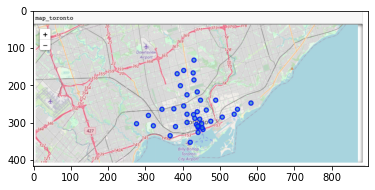

In [178]:
img = mpimg.imread('Screenshot 2020-12-01 at 11.25.20.png')
imgplot = plt.imshow(img)
plt.show()

#### Foursquare data


In [159]:
CLIENT_ID = 'N4JYMKA3RZZCDDNABWVMV3D4HNAXHKKUVYJQBZNBTUKOPICV' # your Foursquare ID
CLIENT_SECRET = 'E4DMWWD0YZXEZNRI3PDGAGZ2T1KWABFJWSQPD5EXEJISGBP2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: N4JYMKA3RZZCDDNABWVMV3D4HNAXHKKUVYJQBZNBTUKOPICV
CLIENT_SECRET:E4DMWWD0YZXEZNRI3PDGAGZ2T1KWABFJWSQPD5EXEJISGBP2


#### Function to iterate venue for each neighborhood in Toronto


In [160]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [161]:
df_toronto.tail()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
34,M6P,West Toronto,"High Park, The Junction South",43.661608,-79.464763
35,M6R,West Toronto,"Parkdale, Roncesvalles",43.648960,-79.456325
36,M6S,West Toronto,"Runnymede, Swansea",43.651571,-79.484450
37,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
38,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558


In [39]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighbourhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West,  Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High

In [162]:
print(toronto_venues.shape)
toronto_venues.head(3)

(1624, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub


In [163]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 235 uniques categories.


### Analyzing the data

In [164]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [165]:
toronto_onehot.shape

(1624, 235)

### grouping by mean

In [166]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head(4)

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar
0,Berczy Park,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0,...,0.018182,0.0,0.0,0.0,0.0,0.0,0.018182,0.0,0.0,0.0
1,"Brockton, Parkdale Village, Exhibition Place",0.0,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,"Business reply mail Processing Centre, South C...",0.0,0.0,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.0,0.0,0.0625,0.0625,0.0625,0.125,0.125,0.0625,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [167]:
toronto_grouped.shape

(39, 235)

#### Putting 6 top venues in final dataframe


In [168]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [169]:
num_top_venues = 8

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Seafood Restaurant,Farmers Market,Cheese Shop,Beer Bar,Restaurant
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Nightclub,Performing Arts Venue,Convenience Store,Bar,Bakery
2,"Business reply mail Processing Centre, South C...",Auto Workshop,Park,Fast Food Restaurant,Light Rail Station,Farmers Market,Recording Studio,Burrito Place,Pizza Place
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Coffee Shop,Harbor / Marina,Plane,Rental Car Location,Sculpture Garden,Boutique
4,Central Bay Street,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Salad Place,Department Store,Thai Restaurant,Japanese Restaurant


## 3.Clustering Neighborhoods

In [170]:
# set number of clusters
kclusters = 7

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_
# add clustering labels
neighborhoods_venues_sorted['Cluster Labels']= kmeans.labels_

In [171]:
toronto_merged = df_toronto

toronto_merged=toronto_merged.rename(columns={'Neighbourhood': 'Neighborhood',
    })
# merge _data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'),
                                     on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,Cluster Labels
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,Pub,Trail,Health Food Store,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,6
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,Greek Restaurant,Coffee Shop,Italian Restaurant,Furniture / Home Store,Bookstore,Ice Cream Shop,Restaurant,Pizza Place,0
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,Park,Steakhouse,Ice Cream Shop,Fish & Chips Shop,Pub,Sandwich Place,Burrito Place,Sushi Restaurant,0
3,M4M,East Toronto,Studio District,43.659526,-79.340923,Coffee Shop,American Restaurant,Bakery,Brewery,Café,Gastropub,Wine Bar,Fish Market,0
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,Park,Bus Line,Swim School,Wine Bar,Deli / Bodega,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,5


In [172]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'],
                                  toronto_merged['Longitude'],
                                  toronto_merged['Neighborhood'],
                                  toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

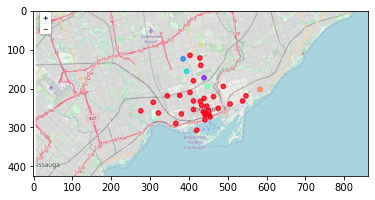

In [180]:
img = mpimg.imread('Screenshot 2020-12-01 at 11.27.16.png')
imgplot = plt.imshow(img)
plt.show()